# Introduction

In this section, we will calculate metrics to assess the effectiveness of advertising investments for the company Showz. Showz is a business that sells tickets for events through its website and is interested in identifying the positive and negative aspects over the course of a year of data collection.

1. We will analyze user behavior, identifying their purchasing times and their relevance to the company.
2. We will validate sales volumes over time, establishing cohorts.
3. We will calculate ROMI (Return on Marketing Investment) for each advertising source and over time, determining the value for each user.
   
Finally, we will provide conclusions that will help in decision-making and offer a clearer view for future investments.

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
visits = pd.read_csv('/datasets/visits_log_us.csv') 
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [28]:
visits = visits.rename(columns = {"End Ts":"End_Ts", "Source Id":"Source_Id", "Start Ts":"Start_Ts"})
visits = visits.rename(str.lower, axis = 'columns')
orders = orders.rename(columns = {"Buy Ts":"Buy_Ts"})
orders = orders.rename(str.lower, axis = 'columns') # I modified the column names to facilitate data processing throughout the analysis

In [29]:
visits['device'] = visits['device'].astype('category') # I optimized the 'device' column by setting it as a category to reduce the volume of the database
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = "%Y-%m-%d %H:%M:%S") # I modified the columns with dates taking the necessary format, this helps us to process the information in the future and to reduce the size of the information

In [30]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = "%Y-%m-%d %H:%M:%S")

In [31]:
costs['dt'] = pd.to_datetime(costs['dt'], format = "%Y-%m-%d %H:%M:%S")

In [32]:
print(visits.info())
print(orders.info())
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entr

In [33]:
# establish the necessary criteria to analyze user behavior, separating the information 
# per year, month and week

visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

print(visits.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year  session_month  session_week  \
0  16879256277535980062          2017             12            51   
1    104060357244891740          2018              2             8   
2   7459035603376831527          2017              7            26   
3  16174680259334210214          2018              5            20   
4   9969694820036681168          2017             12            52   

  session_date  
0   2017-12-20  
1   2018-02-19  
2   2017-07-01  
3   2018-05-20  
4   2017-12-27  


In [34]:
# calculation of the dau, wau y mau

dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_total = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean()
mao_total = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'}).mean()
print(f'Total daily users =', (int(dau_total)))
print(f'Total weekly users =',(int(wau_total)))
print(f'Total monthly users =',(int(mao_total)))

Usuarios diarios totales = 907
Usuarios semanales totales = 5716
Usuarios mensuales totales = 23228


In [35]:
# Calculation of number of sessions per day

session_per_day = visits.groupby('session_date').agg({'uid':['count']}).mean()

print(f'Number of sessions per day =',(int(session_per_day)))

# Calculation of average duration of each session

visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts'])
visits['session_duration_sec'] = visits['session_duration_sec'].dt.seconds
print(f'Average time of each session in minutes =',(visits['session_duration_sec'].mean())/60)

# Calculation of average sessions per user

sessions_per_user = visits.groupby('uid').agg({'session_date':['count']}).mean()

print(f'Average number of sessions per user =', (int(sessions_per_user)))

Numero de sesiones por dia = 987
Promedio de tiempo de cada sesion por minutos = 10.725108143201632
Numero de sesiones promedio por usuario = 1


In [36]:
# Calculation of conversion days on first purchase
# We create a new DataFrame since the dates we are going to compare are the first date of registration, against the first date of purchase
orders['buy_date'] = orders['buy_ts'].dt.date
first_session_by_customer = visits.groupby('uid')['session_date'].min()
first_session_by_customer.name = 'first_session_date'
first_order_by_customer = orders.groupby('uid')['buy_date'].min()
first_order_by_customer.name = 'first_order_date'
convertion_rate = first_order_by_customer.reset_index()
convertion_rate = convertion_rate.join(first_session_by_customer, on = 'uid')

# User Behavior Analysis

Here, we observe that the main characteristic of the website is the traffic of unique users. By this, we mean that it is not a site with frequent users; rather, the average number of sessions per user reflects this reality. We have over 900 sessions per day, but each day involves different clients. This doesn’t seem to be an unusual behavior, given the nature of the business. Each user is primarily interested in the events that align with their interests. Once they obtain their ticket, they are unlikely to return to the website until another event of interest arises.

In [37]:
convertion_rate['convertion'] = (convertion_rate['first_order_date'] - convertion_rate['first_session_date'])/np.timedelta64(1, 'M')
convertion_rate['convertion'] = convertion_rate['convertion'].round().astype('int')
convertion_rate['first_order_month'] = convertion_rate['first_order_date'].astype('datetime64[M]')
convertion_filter = convertion_rate[convertion_rate['convertion'] < 13]

<AxesSubplot:title={'center':'Ciclo de vida, dias en los que se tarda en realizar una compra'}, xlabel='convertion', ylabel='first_order_month'>

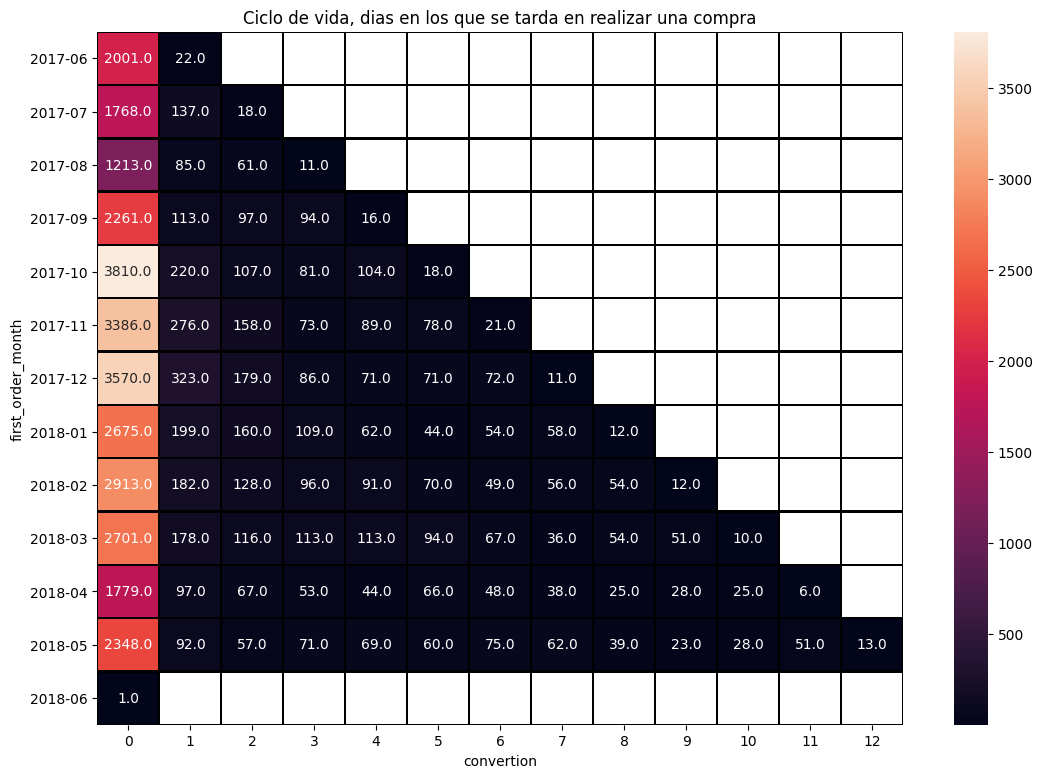

In [38]:
convertion_group = convertion_filter.groupby(['first_order_month','convertion'])['uid'].count()
convertion_group = convertion_group.to_frame()
convertion_group = convertion_group.reset_index()

convertion_group['first_order_month'] = convertion_group['first_order_month'].dt.strftime('%Y-%m')

lifetime = convertion_group.pivot_table(index='first_order_month', columns = 'convertion', values ='uid', aggfunc='sum')

plt.figure(figsize = (13, 9))
plt.title('Life cycle, days it takes to make a purchase')
sns.heatmap(lifetime, annot = True, fmt= ".1f", linewidths = 1, linecolor = 'black')


In [39]:
# Calculation of number of orders per month
orders = orders.join(first_order_by_customer, on = 'uid')

<AxesSubplot:title={'center':'Numero de pedidos por cohorte'}, xlabel='order_month', ylabel='first_order_month'>

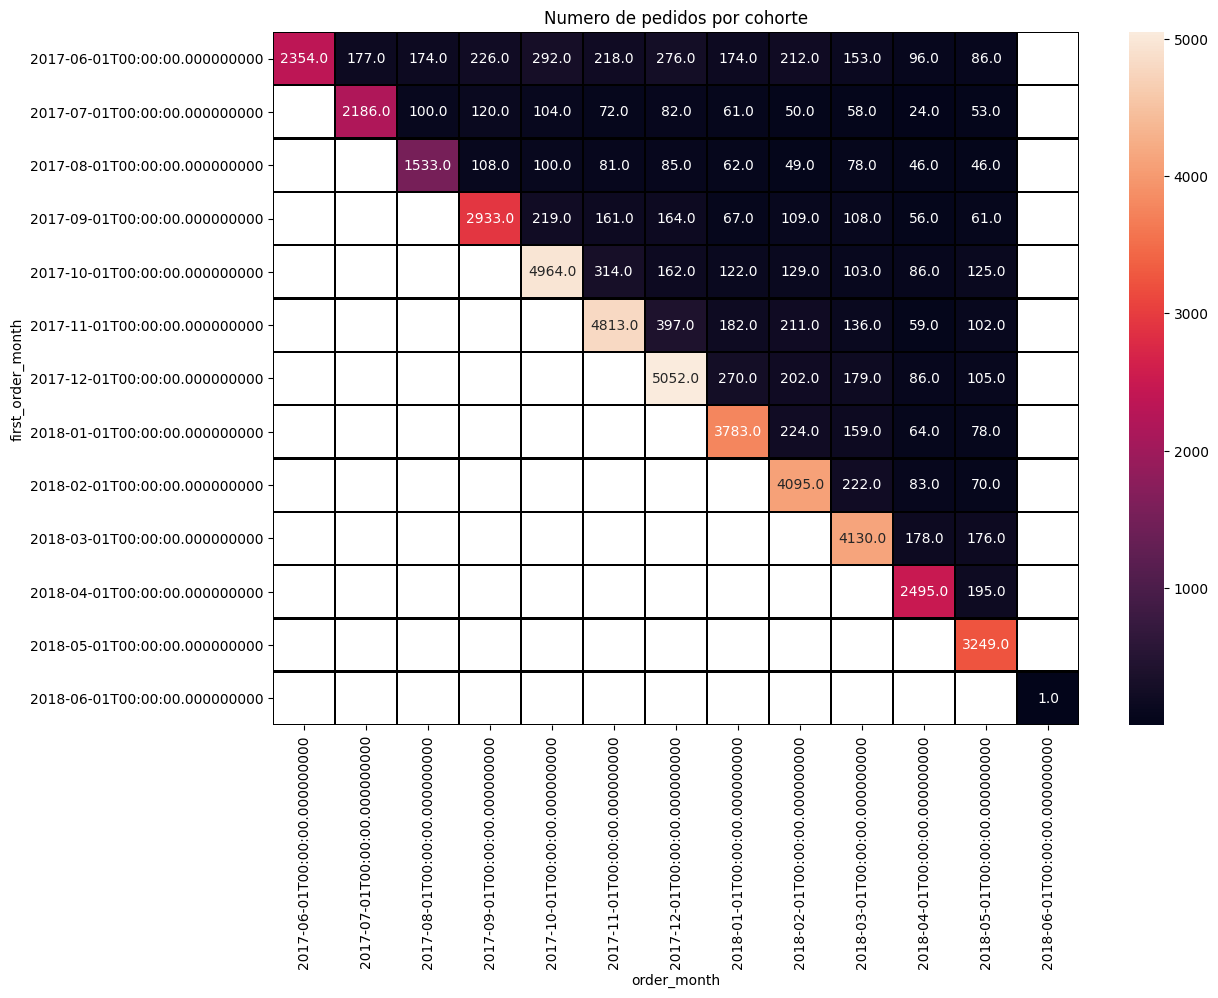

In [40]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_date'].astype('datetime64[M]')
va_mount_orders = orders.pivot_table(index = 'first_order_month', columns = 'order_month', values = 'uid', aggfunc = 'count')


plt.figure(figsize = (13, 9))
plt.title('Number of orders per cohort')
sns.heatmap(va_mount_orders, annot = True, fmt= ".1f", linewidths = 1, linecolor = 'black')


<AxesSubplot:title={'center':'Ingreso por cohorte'}, xlabel='order_month', ylabel='first_order_month'>

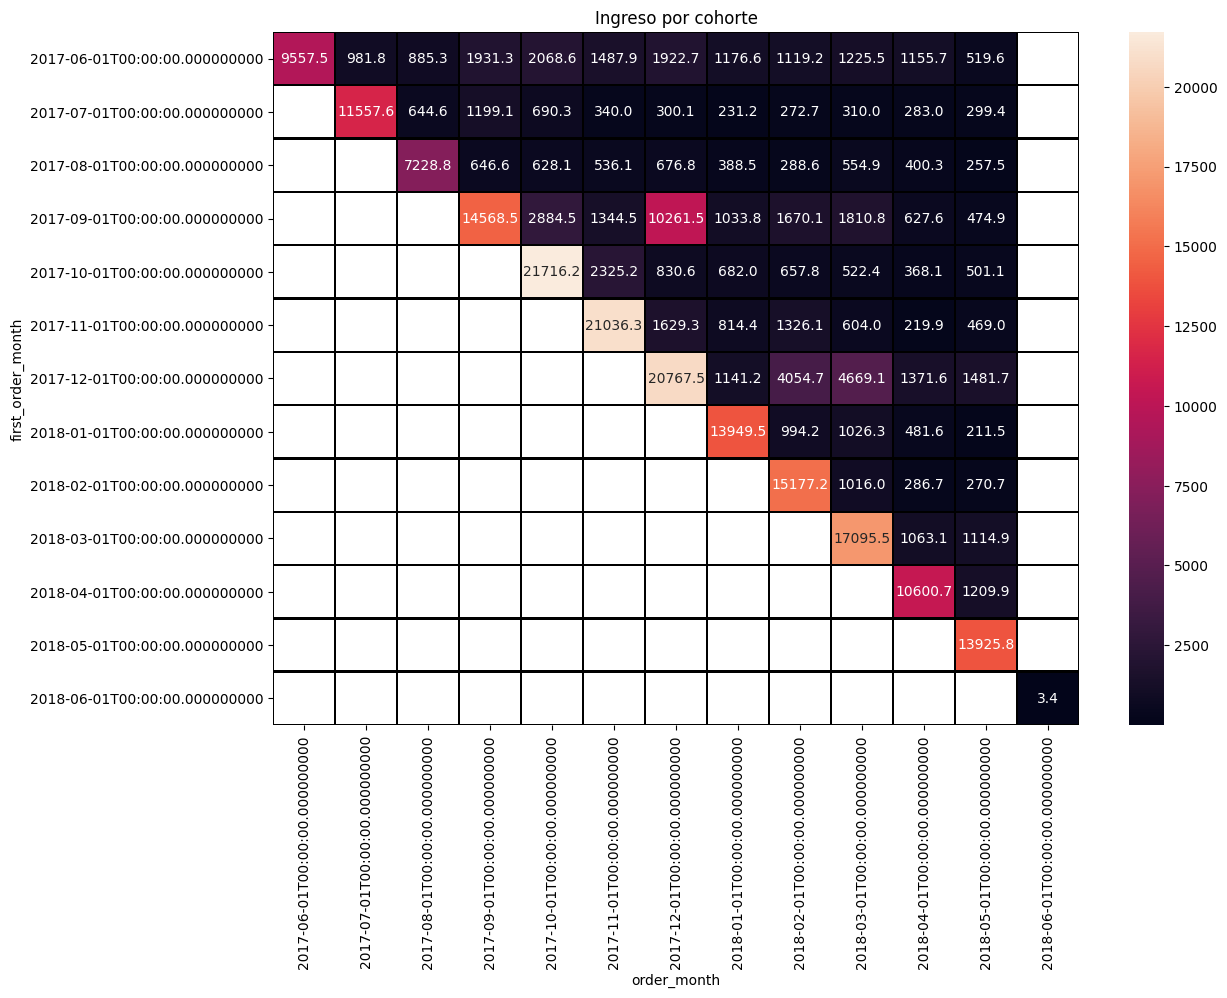

In [63]:
# calculating the size of income per month

orders_group = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_group['revenue_per_user'] = orders_group['revenue']/orders_group['uid']

va_size_revenue = orders_group.pivot_table(index = 'first_order_month', columns = 'order_month', values = 'revenue', aggfunc = 'sum')


plt.figure(figsize = (13, 9))
plt.title('Income by cohort')
sns.heatmap(va_size_revenue, annot = True, fmt= ".1f", linewidths = 1, linecolor = 'black')



# Sales Analysis

Confirming the hypotheses proposed in the user analysis, the sales analysis shows that the first sessions for users are the most relevant. The life cycle analysis reveals that the largest volume of data occurs on day 0, indicating that users register on the website with the intent to make a purchase directly. The sales behavior is very similar across all cohorts, with a high volume of sales during the initial purchases, followed by a drop in the following months. This analysis could be complemented with a joint analysis of the company’s event calendar to assess the impact of each event on sales, as this is the primary reason why customers make purchases on the website.

<AxesSubplot:title={'center':'LTV por edad'}, xlabel='age', ylabel='first_order_month'>

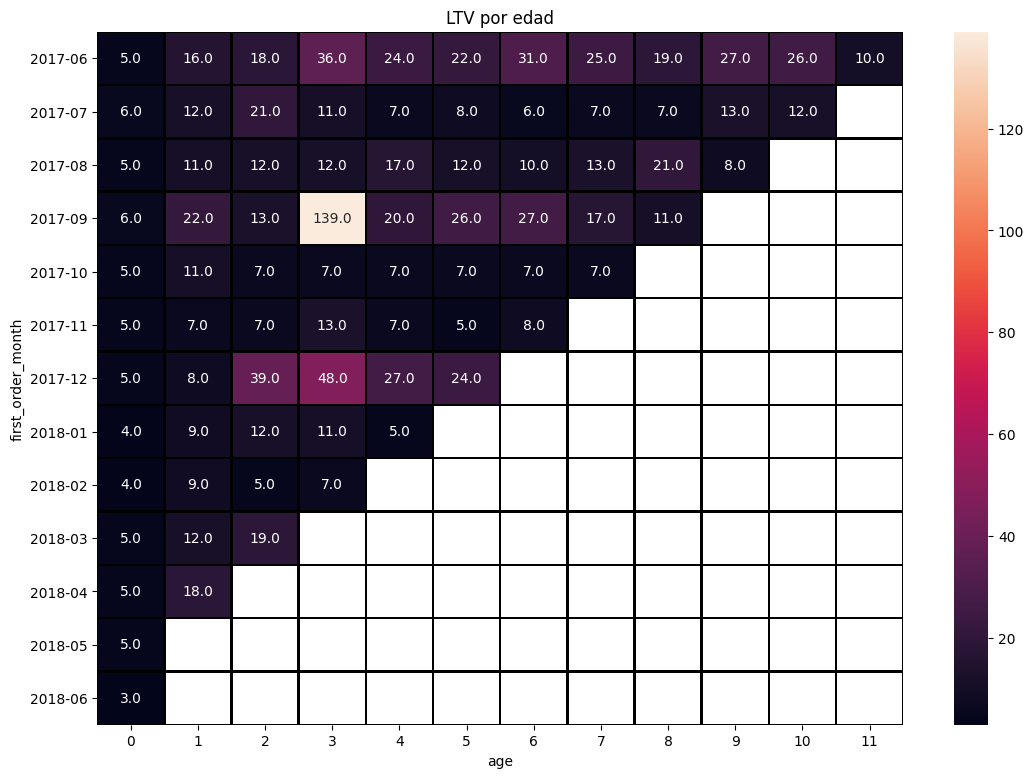

In [42]:
# LTV value calculation by cut-off age

ltv_month = orders_group.groupby(['first_order_month','order_month'])['revenue_per_user'].sum()
ltv_month = ltv_month.reset_index()
ltv_month = ltv_month.rename(columns = {'order_month':'month','revenue_per_user':'ltv'})
ltv_month = ltv_month.rename(str.lower, axis = 'columns')
ltv_month['age'] = (ltv_month['month'] - ltv_month['first_order_month'])/np.timedelta64(1, 'M')
ltv_month['age'] = ltv_month['age'].round().astype('int')
ltv_month['first_order_month'] = ltv_month['first_order_month'].dt.strftime('%Y-%m')
report_ltv = ltv_month.pivot_table(index = 'first_order_month', columns = 'age', values = 'ltv', aggfunc = 'mean').round()

plt.figure(figsize = (13, 9))
plt.title('LTV by age of cohort')
sns.heatmap(report_ltv, annot = True, fmt= ".1f", linewidths = 1, linecolor = 'black')

In [43]:
# Calculation of romi by source

visits = visits.join(first_session_by_customer, on = 'uid')

In [44]:
uid_revenue = orders.groupby('uid')['revenue'].sum()
visits = visits.join(uid_revenue, on = 'uid')

<AxesSubplot:title={'center':'ROMI acumulado por fuente'}, xlabel='month', ylabel='source_id'>

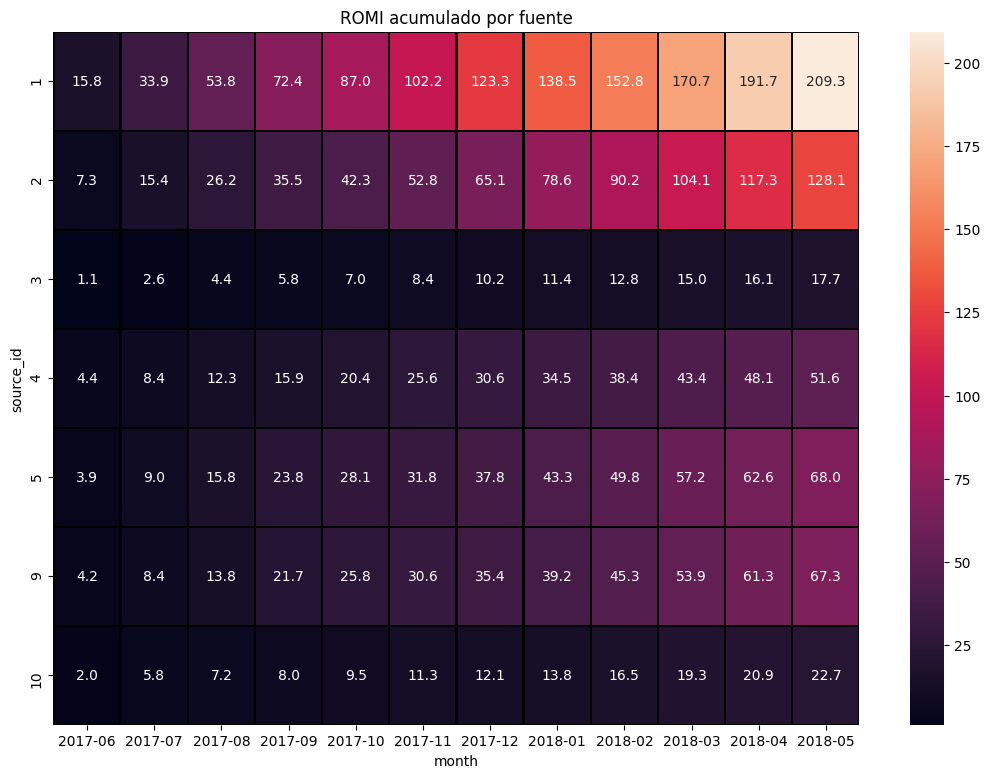

In [61]:
costs['month'] = costs['dt'].astype('datetime64[M]')
visits['month'] = visits['start_ts'].astype('datetime64[M]')


total_cost_month = costs.groupby(['source_id','month'])['costs'].sum()
total_cost_month = total_cost_month.reset_index()
users_by_source = visits.groupby(['source_id','month','uid'])['revenue'].mean()
users_by_source = users_by_source.reset_index()
source_revenue = users_by_source.groupby(['source_id','month']).agg({'revenue':'sum', 'uid':'nunique'})


source_report = total_cost_month.merge(source_revenue, on = ['source_id','month'])
source_report['month'] = source_report['month'].dt.strftime('%Y-%m')
source_report['cac'] = source_report['costs']/source_report['uid']
source_report['ltv'] = source_report['revenue']/source_report['uid']
source_report['romi'] = source_report['ltv']/source_report['cac']
report_cac = source_report.groupby('month')['cac'].sum()
romi_source = source_report.pivot_table(index= 'source_id', columns = 'month', values = 'romi')
romi_source_ = romi_source.cumsum(axis=1).round(2)
plt.figure(figsize = (13, 9))
plt.title('ROMI accumulated by source')
sns.heatmap(romi_source_, annot = True, fmt= ".1f", linewidths = 1, linecolor = 'black')

In [54]:
romi_report = ltv_month.join(report_cac, on = 'month')

<AxesSubplot:title={'center':'ROMI acumulado por periodo de tiempo'}, xlabel='age', ylabel='first_order_month'>

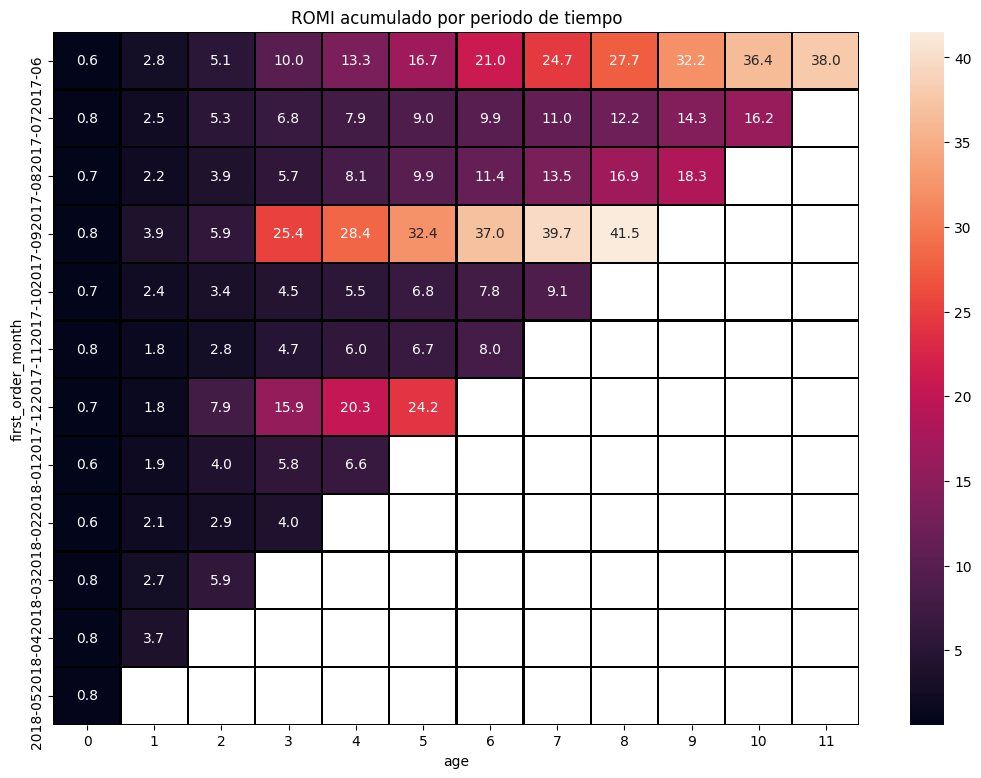

In [57]:
romi_report['romi'] = romi_report['ltv']/romi_report['cac']

output = romi_report.pivot_table(index='first_order_month', columns = 'age', values= 'romi', aggfunc = 'mean')
output_ = output.cumsum(axis=1).round(2)

plt.figure(figsize = (13, 9))
plt.title('ROMI accumulated per time period')
sns.heatmap(output_, annot = True, fmt= ".1f", linewidths = 1, linecolor = 'black')

# Final Analysis

In the final analysis, we present the results of the most important metrics to determine an appropriate evaluation of marketing investments. The first relevant calculation is associated with ROMI by user source. Thanks to the heatmap, we can see that sources 1 and 2 are the most influential and should definitely be maintained over time. Each source generated revenue for the company, but sources 3 and 10 showed the worst results. The ROMI balance per user is very positive at the end of each period, and a favorable outcome is expected for the younger cohorts.

However, despite the positive results from the sources, these need to be compared with the events Showz has worked with. While advertising sources drive users to the site, it is ultimately the individual interests of each user that determine the purchase. If a user receives ads for events that are not of their interest, they will never visit the site to make a purchase. The success of ticket sales depends on the public’s interest, followed by the distribution methods used.

# Relevant Data

1. The average user makes a purchase on the same day they register, and their interaction is based on their interests.
2. Revenue and expenses are higher during the first stage.
3. ROMI for each cohort shows exponential growth, which is favorable for the company.

# Recomendaciones
1. Evaluar el manejo de los gastos para los primeros cohortes, los romi para las primeras etapas son muy bajos y es cuando se recibe más dinero también, puede existis un riesgo si se evalua mal un evento y se realiza un inversión grande en marketing para su distribución.
2. El impacto de las fuentes de usuarios debe ser evaluado con el impacto del evento, alguno eventos son tan llamativos para los usuarios, que pueden no necesitar mucho gasto publicitario.
3. El éxito de la empresa radica en el tipo de evento para el que vaya a trabajar, su servicio siempre debe estar enfocado en favorecer a los organizadores del evento, ellos son los verdaderos clientes.